In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Setup
nltk.download('vader_lexicon', quiet=True)
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
os.makedirs('../visualizations', exist_ok=True)

print("Setup complete")

In [ ]:
def safe_load_csv(path):
    """Load CSV with bulletproof parsing"""
    df = pd.read_csv(
        path,
        sep=',',
        encoding='utf-8',
        skipinitialspace=True,
        na_values=['', 'NA', 'null', 'nan']
    )
    df.columns = df.columns.str.strip()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.strip()
    return df

datasets = {
    'market_size': '../data/clean/market_size_quickcom_india.csv',
    'ecom_overall': '../data/clean/ecom_overall_india.csv',
    'competitors': '../data/clean/competitors_quickcom_india.csv',
    'financials': '../data/clean/swiggy_dunzo_financials.csv',
    'behavior': '../data/clean/E-commerce Customer Behavior - Sheet1.csv',
    'transactions': '../data/clean/Augmented_IndiaTransactMultiFacet2024.csv',
    'survey': '../data/clean/Customer_Behaviour_Survey_responses.csv',
    'trends': '../data/clean/multiTimeline.csv'
}

data = {}
for name, path in datasets.items():
    if os.path.exists(path):
        data[name] = safe_load_csv(path)
        # Convert numerics
        for col in data[name].columns:
            if col not in ['company', 'fiscal_year']:
                data[name][col] = pd.to_numeric(data[name][col], errors='coerce')
        print(f"✅ Loaded {name}: {data[name].shape}")
    else:
        print(f"❌ Missing: {path}")

market_size = data.get('market_size')
competitors = data.get('competitors')
financials = data.get('financials')
behavior = data.get('behavior')
transactions = data.get('transactions')
trends = data.get('trends')

✅ Loaded market_size: (11, 4)
✅ Loaded ecom_overall: (5, 3)
✅ Loaded competitors: (6, 8)
✅ Loaded financials: (4, 8)
✅ Loaded behavior: (350, 11)
✅ Loaded transactions: (10267, 21)
✅ Loaded survey: (254, 18)
✅ Loaded trends: (71, 1)



📊 1/6: Market Sizing
Quick-Commerce CAGR (2023-2028): 30.9%


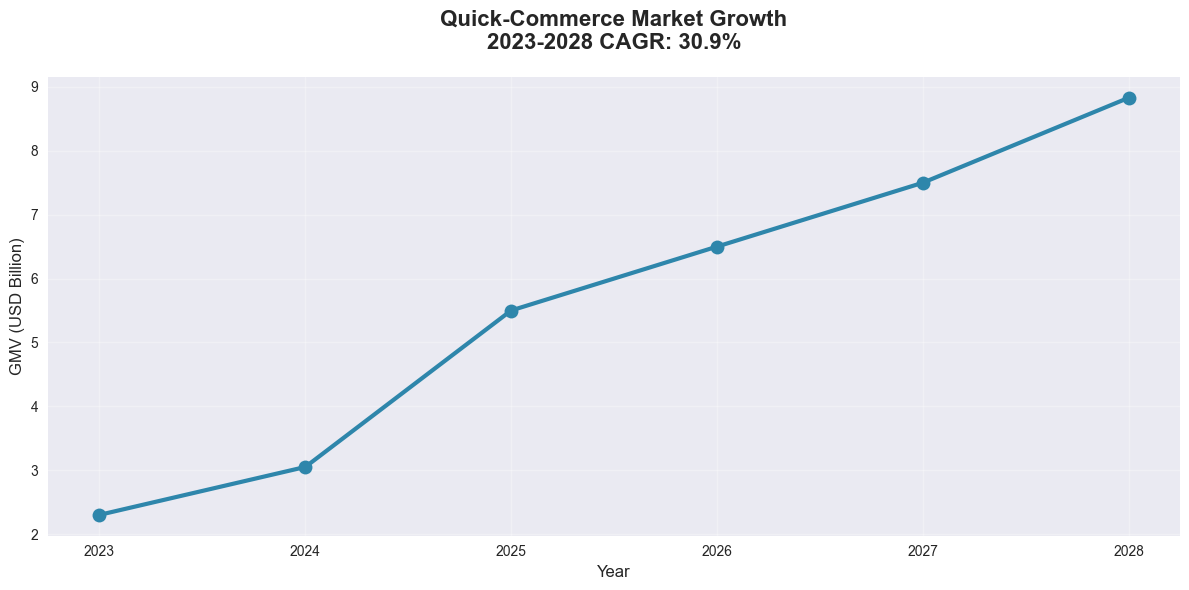

In [15]:
print("\n📊 1/6: Market Sizing")

market_23_28 = market_size[(market_size['year'] >= 2023) & (market_size['year'] <= 2028)]

cagr = ((market_23_28.iloc[-1]['gmv_usd_billion'] / market_23_28.iloc[0]['gmv_usd_billion']) ** (1/5) - 1) * 100
print(f"Quick-Commerce CAGR (2023-2028): {cagr:.1f}%")

plt.figure(figsize=(12, 6))
plt.plot(market_23_28['year'], market_23_28['gmv_usd_billion'], 
         marker='o', linewidth=3, markersize=10, color='#2E86AB')
plt.title('Quick-Commerce Market Growth\n2023-2028 CAGR: {:.1f}%'.format(cagr), 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GMV (USD Billion)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/01_market_growth.png', dpi=300, bbox_inches='tight')
plt.show()


2/6: Competitor Analysis
Raw competitors data:
   company  fiscal_year  market_share_pct
0      NaN          NaN              45.0
1      NaN          NaN              45.0
2      NaN          NaN              27.0
3      NaN          NaN               NaN
4      NaN          NaN               NaN
5      NaN          NaN               NaN
fiscal_year dtype: float64
Found 0 rows with FY24
Final plot data:
Empty DataFrame
Columns: [company, share_clean]
Index: []


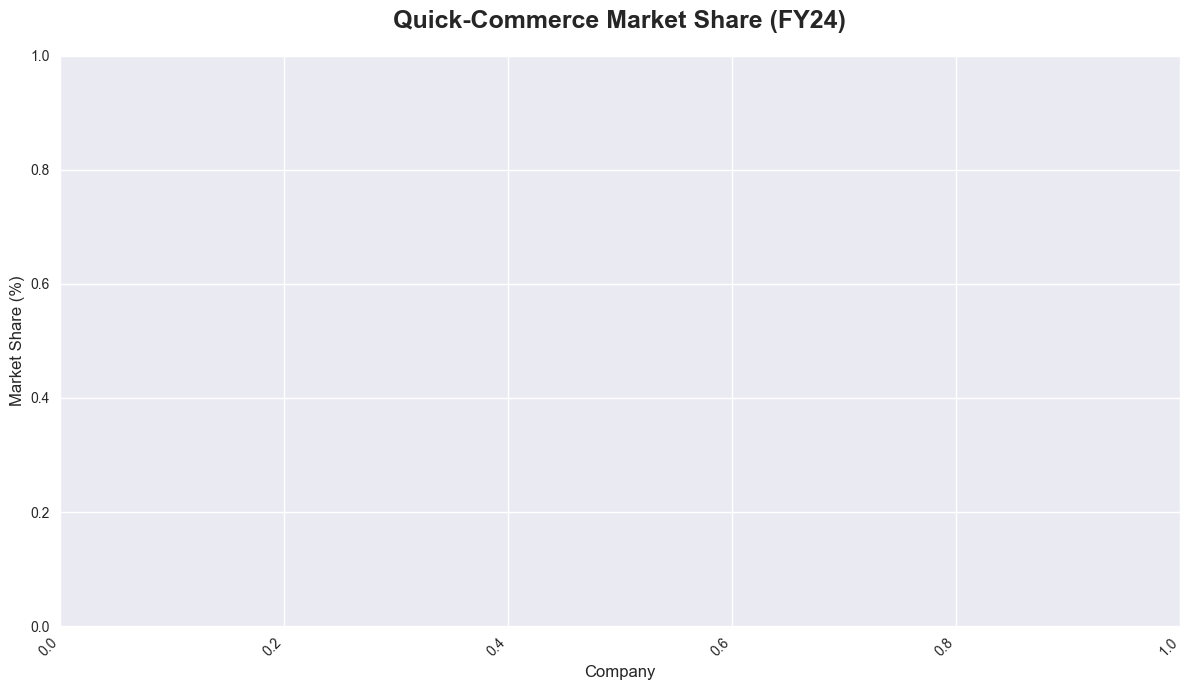

In [17]:
print("\n2/6: Competitor Analysis")

print("Raw competitors data:")
print(competitors[['company', 'fiscal_year', 'market_share_pct']].head(10))
print("fiscal_year dtype:", competitors['fiscal_year'].dtype)

competitors['fiscal_year'] = competitors['fiscal_year'].astype(str).str.strip()

fy24_mask = competitors['fiscal_year'].str.contains('FY24', case=False, na=False)
competitors_24 = competitors[fy24_mask].copy()

print(f"Found {len(competitors_24)} rows with FY24")

def clean_share(val):
    if pd.isna(val): return np.nan
    val = str(val).strip()
    if '-' in val:
        return float(val.split('-')[0])
    return float(val)

competitors_24['share_clean'] = competitors_24['market_share_pct'].apply(clean_share)
plot_data = competitors_24.dropna(subset=['share_clean'])

print("Final plot data:")
print(plot_data[['company', 'share_clean']])

plt.figure(figsize=(12, 7))
bars = sns.barplot(
    data=plot_data,
    x='company',
    y='share_clean',
    hue='company',  
    palette='viridis',
    edgecolor='black',
    legend=False
)
plt.title('Quick-Commerce Market Share (FY24)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Market Share (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar in bars.patches:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}%',
                 (bar.get_x() + bar.get_width()/2, height + 0.5),
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/02_competitor_share.png', dpi=300, bbox_inches='tight')
plt.show()